In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2, os
from tqdm import tqdm
import matplotlib.pyplot as plt

#!pip install pyshp
import shapefile

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

---
## 1. Collect data

CEPs data from correios

In [2]:
cur.execute("SELECT * FROM edne.log_logradouro_sp")
data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
data.head()


,log_nu,ufe_sg,loc_nu,bai_nu_ini,bai_nu_fim,log_no,log_complemento,cep,tlo_tx,log_sta_tlo,log_no_abrev
0,1001235,SP,8912,14716,-1,Octaviano de Arruda Campos,- de 960/961 ao fim,14810227,Avenida,S,Av Octaviano de A Campos
1,1001236,SP,8912,14760,-1,José Salles Gadelha,- até 108/109,14807048,Avenida,S,Av José S Gadelha
2,1001237,SP,8912,14668,-1,José Salles Gadelha,- de 110/111 ao fim,14807126,Avenida,S,Av José S Gadelha
3,1001239,SP,8912,55688,-1,Oswaldo Gonçalves de Jesus,-1,14805396,Avenida,S,Av Oswaldo G de Jesus
4,1001241,SP,8924,56583,-1,Pedro Eroles,"- até km 34,999",07434090,Rodovia,S,Rod Pedro Eroles


Current `susep.geo_info`

In [3]:
cur.execute("SELECT * FROM susep.geo_info")
geo_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
geo_info.head(2)


,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,cod_reg,reg_decirc,cep_ini,cep_fim
0,1,76954000,110001520000004,12060,-12.047040,-62.051736,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
1,777,76873868,110002305000060,11,-9.900819,-63.026831,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999


#### SOME FAST ANALYSIS

All CEPs in Sao Paulo as per correios, and then all CEPs across Brazil in susep.geo_info

In [4]:
display(len(set(data.cep)))
display(len(set(geo_info.CEP)))


306598

562192

If we work with the CEP codes assigned to the state of Sao Paulo as per susep.geo_info

In [5]:
susep_sao_paulo_ceps = set(geo_info[geo_info.code_tract.str.startswith('35')].CEP)
len(susep_sao_paulo_ceps)

181557

Let's see how the two sets relate

In [6]:
print("CEPs assigned to Sao Paulo in susep.geo_info, but not in the correios data:", len(susep_sao_paulo_ceps-set(data.cep)))
print("CEPs of Sao Paulo in correios data but not assigned to Sao Paulo in susep.geo_info:", len(set(data.cep)-susep_sao_paulo_ceps))



CEPs assigned to Sao Paulo in susep.geo_info, but not in the correios data: 14442
CEPs of Sao Paulo in correios data but not assigned to Sao Paulo in susep.geo_info: 139483


We should probably do something with these 14.442 CEPs!? The examples I check seem to be in Sao Paulo so it's weird they are not in the correios data

In [7]:
geo_info[geo_info["CEP"].isin(susep_sao_paulo_ceps-set(data.cep))].head(3)

,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,cod_reg,reg_decirc,cep_ini,cep_fim
2747,5457,00009000,353440105000878,71,-15.562855,-56.290954,NaN,None,None,None,NaN,None,None,None
3013,5548,07990000,351630905000032,1441,-23.142257,-47.535682,11.0,7800,FRANCISCO MORATO,8499,14.0,METROPOLITANA DE S�O PAULO,7800,8499
3365,5661,06950000,352620910000012,14409,-23.923451,-47.072700,11.0,6950,JUQUITIBA,6999,14.0,METROPOLITANA DE S�O PAULO,6950,6999


---

## 2. Assign closest CEP

Assign closest CEP to each missing CEP. First create an indexed 5-digit lookup table

In [8]:
# Sort susep by CEP and get the sorted list of CEPs
geo_info["CEP"] = geo_info["CEP"].astype(int)
geo_info = geo_info.sort_values("CEP").reset_index().drop(columns='index')

# Function to get numeric cep to string
def cep_to_str(number):
    return ("0"*(8-len(str(number)))+str(number))
geo_info['5-digit_level'] = geo_info["CEP"].apply(lambda x: cep_to_str(int(x))[:5])

# Create lookup table
cep_lookup_table = geo_info[["CEP", '5-digit_level']].set_index("CEP").copy()
cep_lookup_table


,5-digit_level
CEP,
1,00000
2,00000
3,00000
4,00000
5,00000
...,...
99999990,99999
99999991,99999
99999996,99999


Exclude from this lookup table all CEPs that:
- Do not start with 0 or 1, as they theoretically do not belong to Sao Paulo, or
- Do not appear among correios data

In [9]:
cep_lookup_table = cep_lookup_table[(cep_lookup_table.index.isin(data.cep.astype(int))) &
                                    ((cep_lookup_table['5-digit_level'].str.startswith('0')) 
                                     | (cep_lookup_table['5-digit_level'].str.startswith('1')))]
cep_lookup_table


,5-digit_level
CEP,
1001000,01001
1001001,01001
1001010,01001
1002000,01002
1002001,01002
...,...
19915734,19915
19915736,19915
19915738,19915


Now get the closest CEP in the 5-digit level if there's any, otherwise just the closest

In [10]:
# Define a fast search function to return closes value in list given a number
from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before


# For each cep
matches = []
for cep in tqdm(set(data.cep)):

    # Compute the match
    match = take_closest(cep_lookup_table.index, int(cep))
    
    # If the match is not in the same 5-digit level
    if cep_to_str(match)[:5]!=cep_to_str(int(cep))[:5]:
        
        # Filter the lookup list to contain only ceps in the same 5-digit level
        tmp_list = list(cep_lookup_table[cep_lookup_table['5-digit_level']==cep_to_str(int(cep))[:5]].index)
        
        # And if there's any, get the closest value within that level as match
        if len(tmp_list)>0:
            match = take_closest(tmp_list, int(cep))
            
    # Append results
    matches.append({'cep': int(cep), 
                    'closest_in_geo_info': match})
        
matches = pd.DataFrame(matches)

# Add an abs distance column and a column indicating whether the 5 digit match is correct
matches['abs_distance'] = (matches.cep-matches.closest_in_geo_info).abs()
matches['match_in_5_digit_prefix'] = matches.cep.astype(str).apply(lambda x: x[0: 5-(8-len(x))])==matches.closest_in_geo_info.astype(str).apply(lambda x: x[0: 5-(8-len(x))])
matches.head()


100%|██████████████████████████████████| 306598/306598 [06:18<00:00, 811.07it/s]


,cep,closest_in_geo_info,abs_distance,match_in_5_digit_prefix
0,13802404,13802430,26,True
1,18304822,18304750,72,True
2,2132140,2132140,0,True
3,3505000,3505000,0,True
4,18131521,18131520,1,True


---

## 3. Filters

Little breakdown of CEPs in the correios data

In [11]:
(matches['abs_distance']==0).value_counts()

True     167774
False    138824
Name: abs_distance, dtype: int64

In [12]:
matches[(matches['abs_distance']!=0)].match_in_5_digit_prefix.value_counts()

True     96238
False    42586
Name: match_in_5_digit_prefix, dtype: int64

Keep only the cases to imputated - inexact match but correct in the first 5 digits

In [13]:
curated_matches = matches[(matches['abs_distance']!=0) & (matches.match_in_5_digit_prefix)].copy()
curated_matches.shape


(96238, 4)

---
## 4. Extra data for further checks

In how many cases the name of the logradouro assigned to the two CEPs is different?

In [14]:
extra_data = []
for i, row in tqdm(curated_matches.iterrows()):
    
    # Get the data
    tmp = data[data['cep'].isin([str(str(row.cep) if len(str(row.cep))==8 else '0'+str(row.cep)),
                             str(str(row.closest_in_geo_info) if len(str(row.closest_in_geo_info))==8 else '0'+str(row.closest_in_geo_info))])]
    
    # if the assigned CEP is also in correios data
    if tmp.shape[0]==2:
        assigned_in_correios_data = True
        same_loc_nu = tmp.loc_nu.nunique()==1
        same_bai_nu_ini = tmp.bai_nu_ini.nunique()==1
        same_log_no = tmp.log_no.nunique()==1
        
    else:
        assigned_in_correios_data = False
        same_loc_nu = np.nan
        same_bai_nu_ini = np.nan
        same_log_no = np.nan
        
    # APpend to data
    extra_data.append({'assigned_in_correios_data': assigned_in_correios_data, 
                       'same_loc_nu': same_loc_nu,
                       'same_bai_nu_ini': same_bai_nu_ini,
                       'same_log_no': same_log_no})
    

extra_data = pd.DataFrame(extra_data)
extra_data


96238it [20:09, 79.58it/s]


,assigned_in_correios_data,same_loc_nu,same_bai_nu_ini,same_log_no
0,True,True,False,False
1,True,True,False,False
2,True,True,False,False
3,True,True,True,False
4,True,True,True,False
...,...,...,...,...
96233,True,True,False,False
96234,True,True,False,False
96235,True,True,False,False
96236,True,True,True,False


Append to the matches data

In [15]:
curated_matches = pd.concat([curated_matches.reset_index().drop(columns='index'), extra_data], axis=1)
curated_matches.head()


,cep,closest_in_geo_info,abs_distance,match_in_5_digit_prefix,assigned_in_correios_data,same_loc_nu,same_bai_nu_ini,same_log_no
0,13802404,13802430,26,True,True,True,False,False
1,18304822,18304750,72,True,True,True,False,False
2,18131521,18131520,1,True,True,True,False,False
3,3912140,3912130,10,True,True,True,True,False
4,13337330,13337320,10,True,True,True,True,False


---

## 5. Match quality analysis

By contstruction we ensure that every match is among correios data

In [16]:
display(curated_matches.assigned_in_correios_data.value_counts())
curated_matches[~curated_matches['assigned_in_correios_data']].head(2)


True    96238
Name: assigned_in_correios_data, dtype: int64

,cep,closest_in_geo_info,abs_distance,match_in_5_digit_prefix,assigned_in_correios_data,same_loc_nu,same_bai_nu_ini,same_log_no


Is `abs_distance` (diff between CEPs as integers) indicative of geographical distance?


False    95120
True      1118
Name: same_log_no, dtype: int64

None

(0.0, 200.0)

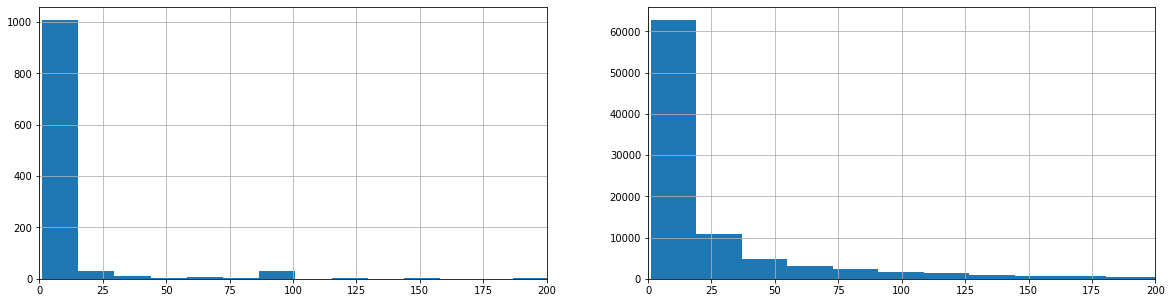

In [17]:
display(display(curated_matches.same_log_no.value_counts()))

fig, axes = plt.subplots(1,2, figsize=(20,5))
curated_matches[curated_matches['same_log_no']==True].abs_distance.hist(bins=50, ax=axes[0])
axes[0].set_xlim((0,200))
curated_matches[curated_matches['same_log_no']==False].abs_distance.hist(bins=50, ax=axes[1])
axes[1].set_xlim((0,200))


True     56151
False    40087
Name: same_bai_nu_ini, dtype: int64

None

(0.0, 200.0)

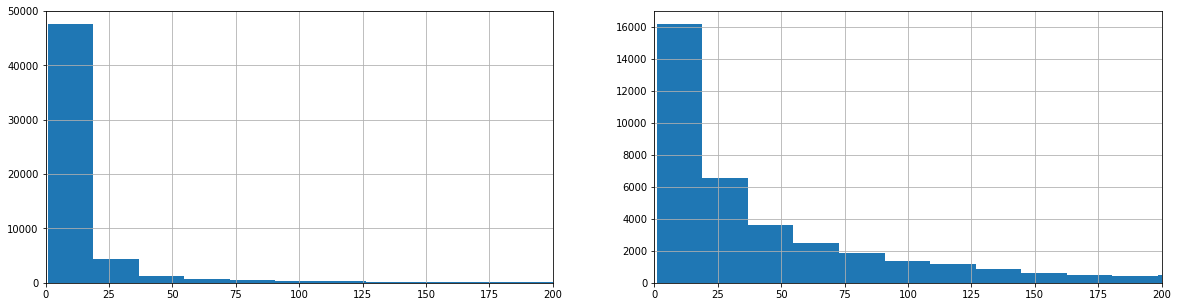

In [18]:
display(display(curated_matches.same_bai_nu_ini.value_counts()))

fig, axes = plt.subplots(1,2, figsize=(20,5))
curated_matches[curated_matches['same_bai_nu_ini']==True].abs_distance.hist(bins=50, ax=axes[0])
axes[0].set_xlim((0,200))
curated_matches[curated_matches['same_bai_nu_ini']==False].abs_distance.hist(bins=50, ax=axes[1])
axes[1].set_xlim((0,200))


It seems reasonable to **limit the matches to those pairs that have the same `bai_nu_ini`, bairro inicial del logradouro**.

In [19]:
final_curated_matches = curated_matches[(curated_matches['same_bai_nu_ini']==True)].copy()
final_curated_matches.shape


(56151, 8)

---

## 6. Check some specific cases

Some relevant cases:

- **Bruno's neighbors**:

In [20]:
display(final_curated_matches[final_curated_matches['cep']==1405100])
display(data[data['cep'].isin(['01405100', '01405003'])])

,cep,closest_in_geo_info,abs_distance,match_in_5_digit_prefix,assigned_in_correios_data,same_loc_nu,same_bai_nu_ini,same_log_no
51155,1405100,1405003,97,True,True,True,True,True


,log_nu,ufe_sg,loc_nu,bai_nu_ini,bai_nu_fim,log_no,log_complemento,cep,tlo_tx,log_sta_tlo,log_no_abrev
245061,620471,SP,9668,26005,-1,Pamplona,- até 599 - lado ímpar,01405100,Rua,S,R Pamplona
290220,859442,SP,9668,26005,-1,Pamplona,- de 1261 ao fim - lado ímpar,01405003,Rua,S,R Pamplona


---

## 7. Create data for `susep.geo_info_enhanced`

Create a second table `susep.geo_info_enhanced` where we introduce the mapped rows. First, clean the mapped table

In [21]:
final_curated_matches = final_curated_matches.rename(columns={'closest_in_geo_info': 'mapped_from',
                                                              'abs_distance': 'mapped_abs_distance',
                                                              'match_in_5_digit_prefix': 'mapped_match_in_5_digit_prefix',
                                                              'same_loc_nu': 'mapped_same_loc_nu',
                                                              'same_bai_nu_ini': 'mapped_same_bai_nu_ini',
                                                              'same_log_no': 'mapped_same_log_no'})

display(final_curated_matches.head())
final_curated_matches.shape



,cep,mapped_from,mapped_abs_distance,mapped_match_in_5_digit_prefix,assigned_in_correios_data,mapped_same_loc_nu,mapped_same_bai_nu_ini,mapped_same_log_no
3,3912140,3912130,10,True,True,True,True,False
4,13337330,13337320,10,True,True,True,True,False
5,13733125,13733120,5,True,True,True,True,False
7,2464010,2464005,5,True,True,True,True,False
8,13450384,13450383,1,True,True,True,True,False


(56151, 8)

Zero padding to 8 digits and str

In [22]:
display(final_curated_matches.cep.astype(str).apply(lambda x: len(x)).value_counts())
final_curated_matches["cep"] = final_curated_matches["cep"].apply(lambda x: str(x) if len(str(x))==8 else "0"+str(x))
display(final_curated_matches.cep.astype(str).apply(lambda x: len(x)).value_counts())

display(final_curated_matches.mapped_from.astype(str).apply(lambda x: len(x)).value_counts())
final_curated_matches["mapped_from"] = final_curated_matches["mapped_from"].apply(lambda x: str(x) if len(str(x))==8 else "0"+str(x))
display(final_curated_matches.mapped_from.astype(str).apply(lambda x: len(x)).value_counts())


8    32044
7    24107
Name: cep, dtype: int64

8    56151
Name: cep, dtype: int64

8    32044
7    24107
Name: mapped_from, dtype: int64

8    56151
Name: mapped_from, dtype: int64

Export and upload to `s3://postgres-staging-data/edne/cep_code_imputations.csv`

In [23]:
final_curated_matches.to_csv('cep_code_imputations.csv', index=False)

Reload geo_info

In [24]:
cur.execute("SELECT * FROM susep.geo_info")
geo_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
geo_info.head(2)


,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,cod_reg,reg_decirc,cep_ini,cep_fim
0,1,76954000,110001520000004,12060,-12.047040,-62.051736,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
1,777,76873868,110002305000060,11,-9.900819,-63.026831,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999


Rebuild `susep.geo_info` by appending the new data

In [25]:
# Insert columns with missing data for existing records
for column in ['mapped_from',
               'mapped_abs_distance',
               'mapped_match_in_5_digit_prefix',
               'assigned_in_correios_data',
               'mapped_same_loc_nu',
               'mapped_same_bai_nu_ini',
               'mapped_same_log_no']:
    geo_info[column]=np.nan


# Create new df
new_data = []
for i,row in tqdm(final_curated_matches.iterrows()):
    
    # Collect a copy of the mapped row
    mapped_row = geo_info[geo_info['CEP']==row['mapped_from']].copy().iloc[0]
    
    # Override its info
    mapped_row['CEP'] = row['cep']
    for field in row.index[1:]:
        mapped_row[field]=row[field]

    # Add to new data
    new_data.append(mapped_row)
    
new_data = pd.DataFrame(new_data)
new_data.head()


56151it [39:56, 23.43it/s]


,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,...,reg_decirc,cep_ini,cep_fim,mapped_from,mapped_abs_distance,mapped_match_in_5_digit_prefix,assigned_in_correios_data,mapped_same_loc_nu,mapped_same_bai_nu_ini,mapped_same_log_no
334800,354569,03912140,355030804000101,25,-23.582878,-46.521239,11.0,1000,S�O PAULO,5999,...,METROPOLITANA DE S�O PAULO,1000,5999,03912130,10,True,True,True,True,False
268007,284722,13337330,352050905000218,13,-23.061700,-47.139589,12.0,13330,INDAIATUBA,13349,...,DEMAIS CAMPINAS 2,13330,13349,13337320,10,True,True,True,True,False
302515,310667,13733125,353050805000067,28,-21.457893,-47.005856,13.0,13730,MOCOCA,13759,...,SOROCABA - CIDADE E REGI�O,13730,13759,13733120,5,True,True,True,True,False
369419,384106,02464010,355030870000130,12,-23.495535,-46.641290,11.0,1000,S�O PAULO,5999,...,METROPOLITANA DE S�O PAULO,1000,5999,02464005,5,True,True,True,True,False
339205,333960,13450384,354580305000016,17,-22.764350,-47.415721,13.0,13450,SANTA BARBARA D�OESTE,13459,...,SOROCABA - CIDADE E REGI�O,13450,13459,13450383,1,True,True,True,True,False


Append the new rows to the dataset

In [26]:
final_data = pd.concat([geo_info, new_data], axis=0).reset_index().drop(columns='index')
final_data.head()

,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,...,reg_decirc,cep_ini,cep_fim,mapped_from,mapped_abs_distance,mapped_match_in_5_digit_prefix,assigned_in_correios_data,mapped_same_loc_nu,mapped_same_bai_nu_ini,mapped_same_log_no
0,1,76954000,110001520000004,12060,-12.047040,-62.051736,39.0,76740,FAINA,76999,...,DEMAIS REGI�ES DE GOI�S,76740,76999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,777,76873868,110002305000060,11,-9.900819,-63.026831,39.0,76740,FAINA,76999,...,DEMAIS REGI�ES DE GOI�S,76740,76999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,76955000,110007205000011,76,-12.983041,-60.952011,39.0,76740,FAINA,76999,...,DEMAIS REGI�ES DE GOI�S,76740,76999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1553,76965748,110004905000051,8,-11.436342,-61.436585,39.0,76740,FAINA,76999,...,DEMAIS REGI�ES DE GOI�S,76740,76999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,76594000,110001505000018,9,-11.928932,-61.990097,39.0,76590,SAO MIGUEL DO ARAGUAIA,76599,...,DEMAIS REGI�ES DE GOI�S,76590,76599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
final_data.mapped_same_log_no.notna().sum()

56151

Export to csv, upload to `s3://postgres-staging-data/edne/geo_info_enhanced.csv`

In [28]:
final_data.to_csv('geo_info_enhanced.csv', index=False)

---

## 8. Create table and insert data to `susep.geo_info_enhanced`

Create a second table `susep.geo_info_enhanced` where we introduce the mapped rows. First, copy the table

In [30]:
cur.execute("CREATE TABLE susep.geo_info_enhanced AS SELECT * FROM susep.geo_info")
conn.commit()


Then insert new, empty columns as appearing in the enriched data

In [31]:
cur.execute("""
    ALTER TABLE susep.geo_info_enhanced
        ADD column mapped_from VARCHAR(8),
        ADD column mapped_abs_distance INTEGER,
        ADD column mapped_match_in_5_digit_prefix BOOL,
        ADD column assigned_in_correios_data BOOL,
        ADD column mapped_same_loc_nu BOOL,
        ADD column mapped_same_bai_nu_ini BOOL,
        ADD column mapped_same_log_no BOOL;
    """)
conn.commit()


Finally insert the records that were not already there

In [32]:
# Select record subset and replace np.nan
data_to_insert = final_data[final_data.mapped_same_log_no.notna()].copy()
data_to_insert = data_to_insert.replace([np.nan], [None])

# Insert the records
for i, record in tqdm(data_to_insert.iterrows()):
    insert_statement = f"""INSERT INTO susep.geo_info_enhanced ("Id", "CEP", {', '.join(record.index[2:])}) VALUES ({', '.join(['%s']*len(record))})"""
    cur.execute(insert_statement,
                tuple([v for k,v in record.items()])
               )
    
conn.commit()


56151it [2:00:47,  7.75it/s]
